In [1]:
from load_data import * 
from model import * 
from test_utils import *
from train_utils import *

## Load Data

In [ ]:

cfg =LoaderConfig(data_dir="./data", batch_size=128, num_workers=0, seed=42)
train_loader, test_loader, classes = create_cifar10_loaders(cfg)
print("Clases:", classes)

x, y = next(iter(train_loader))
print(f"Train batch -> imgs: {tuple(x.shape)}, labels: {tuple(y.shape)}")

100%|██████████| 170M/170M [00:02<00:00, 65.1MB/s]

Clases: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Train batch -> imgs: (128, 3, 32, 32), labels: (128,)

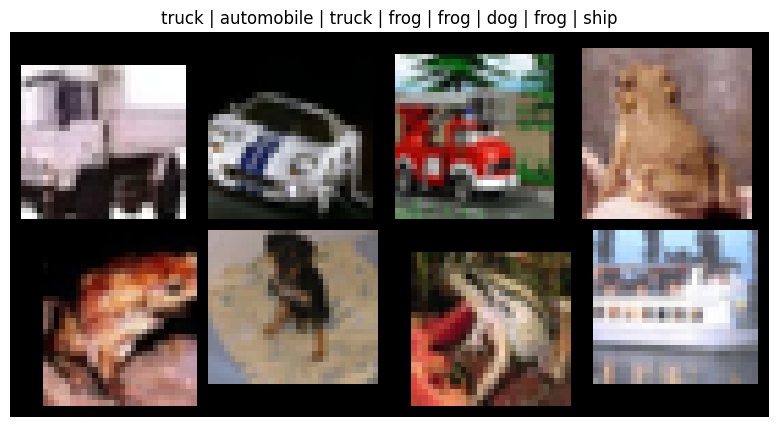

In [37]:

x, y = next(iter(train_loader))
imshow_cifar(x, y, classes, max_samples=8)


## Create and train the model 

In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'


model = ResNet50(num_classes=10, first_block='conv')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

epochs = 10

for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")
    train_metrics = train_epoch_classification(train_loader, model, optimizer, criterion, device=device, amp=False)


Epoch 1/10

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train - loss: 2.7765 | acc@1: 13.54% | acc@3: 38.28%

Epoch 2/10

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train - loss: 1.9383 | acc@1: 23.51% | acc@3: 59.35%

Epoch 3/10

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train - loss: 1.7016 | acc@1: 35.36% | acc@3: 71.60%

Epoch 4/10

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train - loss: 1.5440 | acc@1: 42.53% | acc@3: 77.31%

Epoch 5/10

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train - loss: 1.3989 | acc@1: 48.63% | acc@3: 81.30%

Epoch 6/10

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train - loss: 1.2743 | acc@1: 53.68% | acc@3: 84.19%

Epoch 7/10

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train - loss: 1.1458 | acc@1: 58.90% | acc@3: 86.73%

Epoch 8/10

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train - loss: 1.0360 | acc@1: 62.95% | acc@3: 88.95%

Epoch 9/10

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train - loss: 0.9513 | acc@1: 66.09% | acc@3: 90.51%

Epoch 10/10

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train - loss: 0.8722 | acc@1: 69.07% | acc@3: 91.89%


## Lets see the model architecture 

In [40]:
model

ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (maxpool): Identity()
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer2): Sequential(
    (0): ConvolutionalBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track

## Validate the model 

In [ ]:
val_metrics   = evaluate_classification(test_loader, model, criterion, device=device)

Val  - loss: 0.9182 | acc@1: 67.90% | acc@3: 91.74%

---

## Usefull visualization of the architecture 

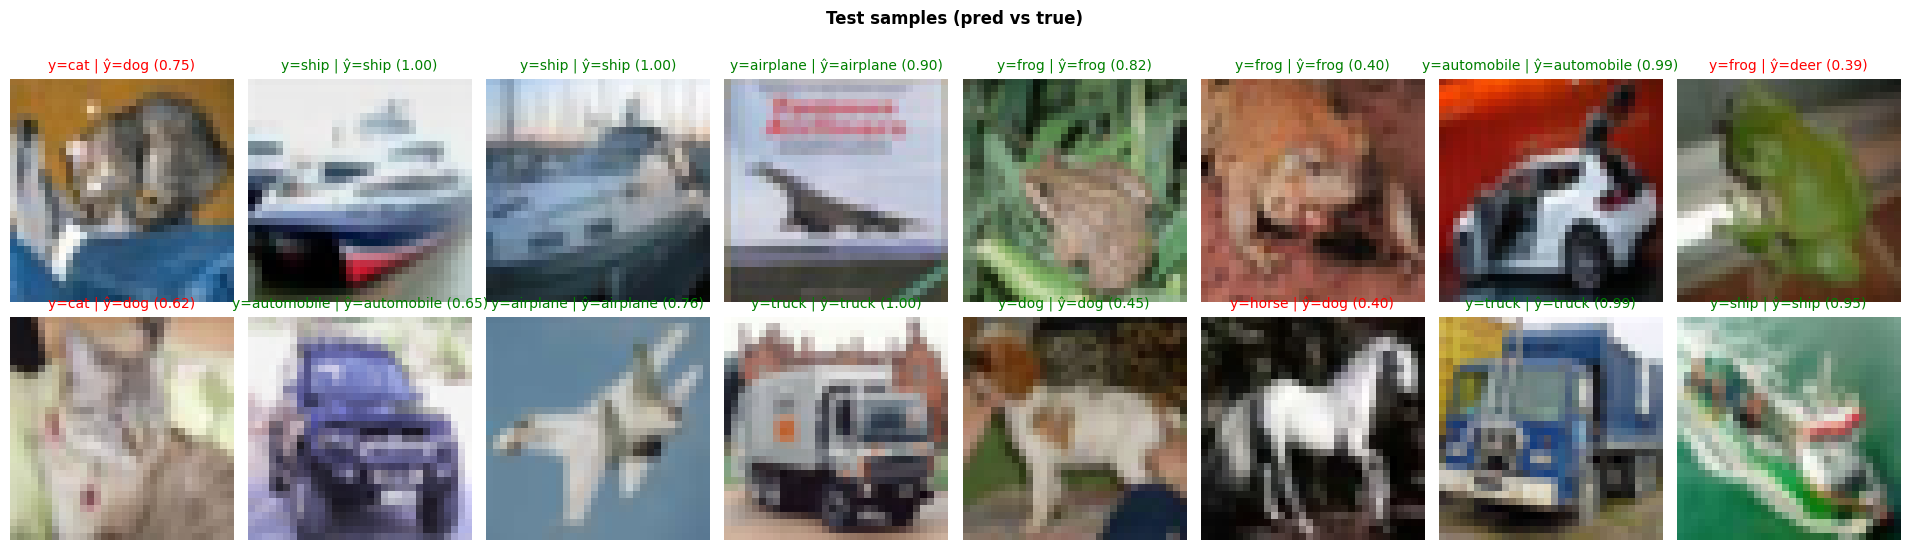

In [38]:
visualize_test_predictions(model, test_loader, device=device, n=16,only_errors=False, classes=classes)

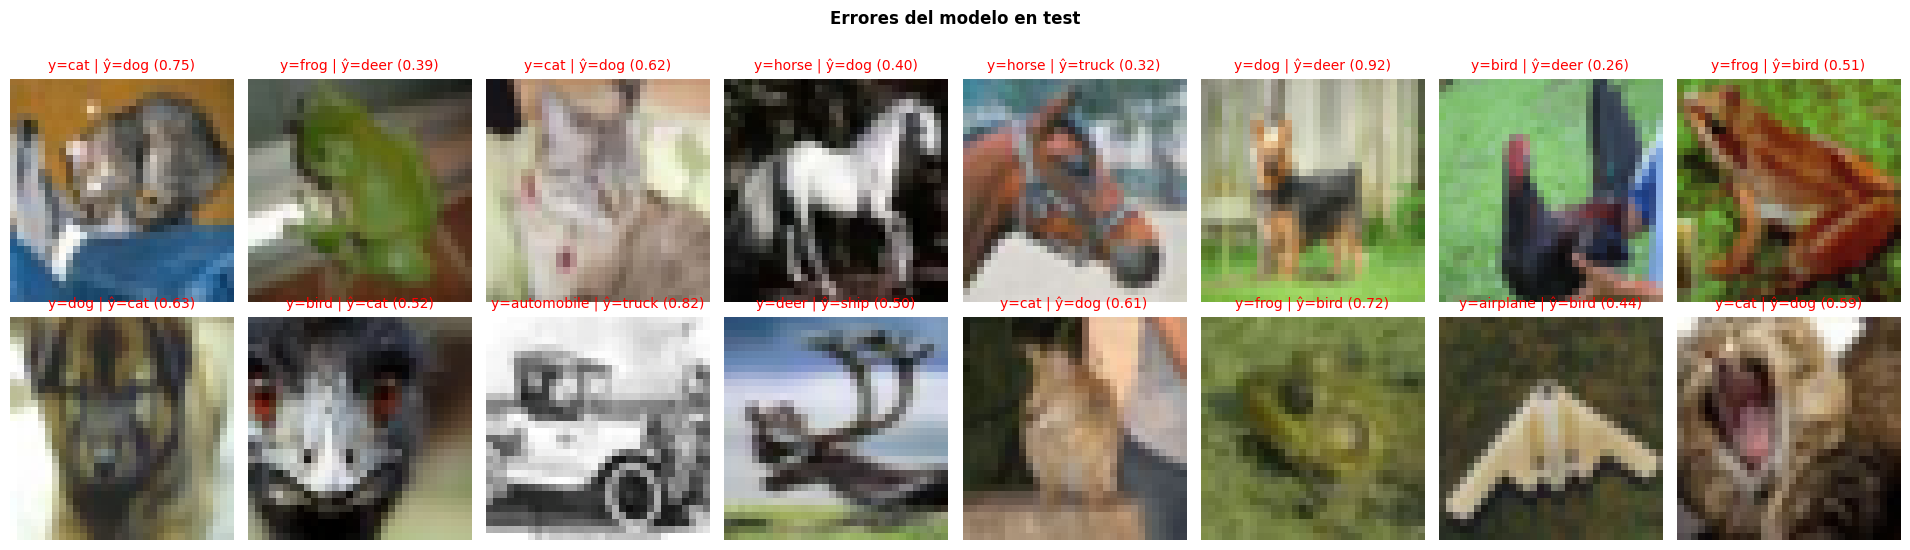

In [39]:
visualize_test_predictions(model, test_loader, device=device, n=16,only_errors=True, classes=classes)

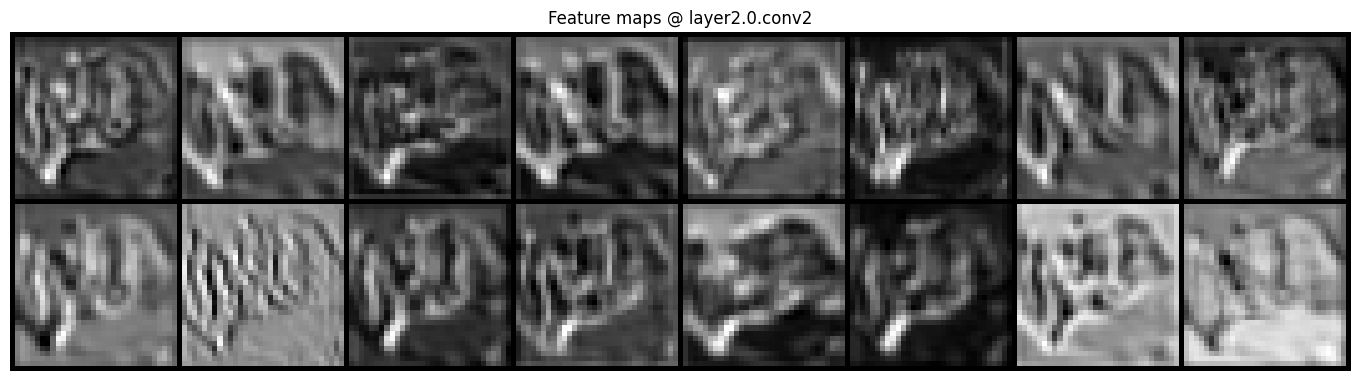

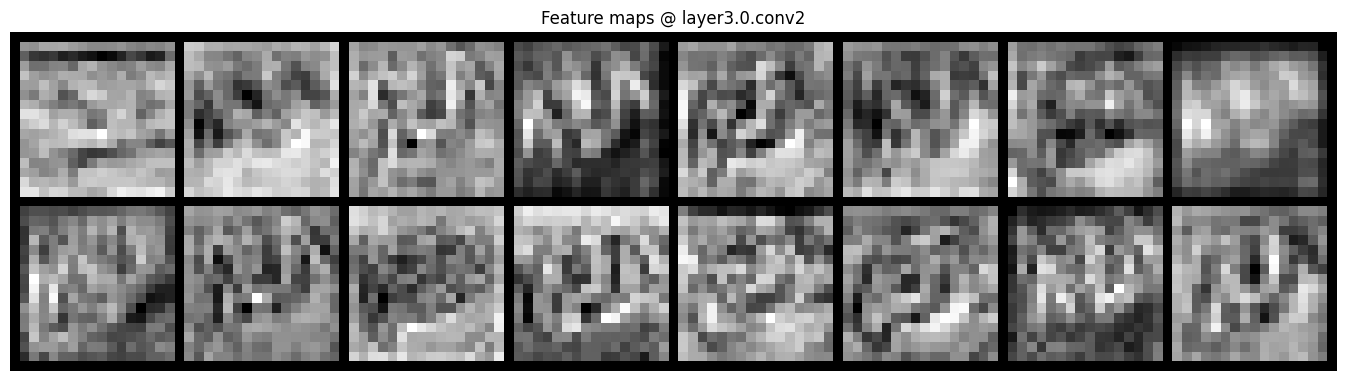

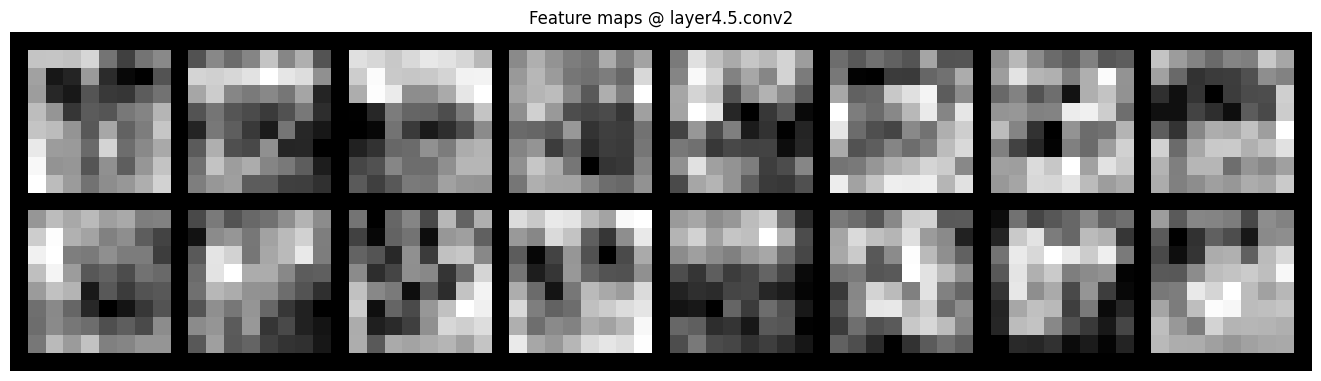

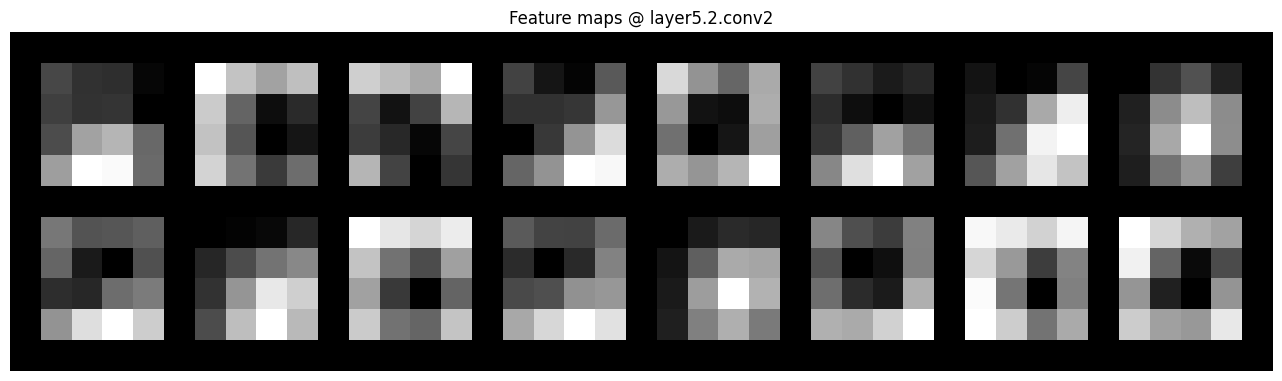

In [25]:
xb, yb = next(iter(test_loader))    # un batch
xb = xb.to(device)

layers_to_peek = ["layer2.0.conv2",
    "layer3.0.conv2", "layer4.5.conv2",
    "layer5.2.conv2", ]

catcher = ActivationCatcher(model, layers_to_peek)
model.eval()
with catcher.capture():
    _ = model(xb)

for name in layers_to_peek:
    show_feature_maps(catcher.activations[name], max_maps=16, ncols=8, title=f"Feature maps @ {name}")


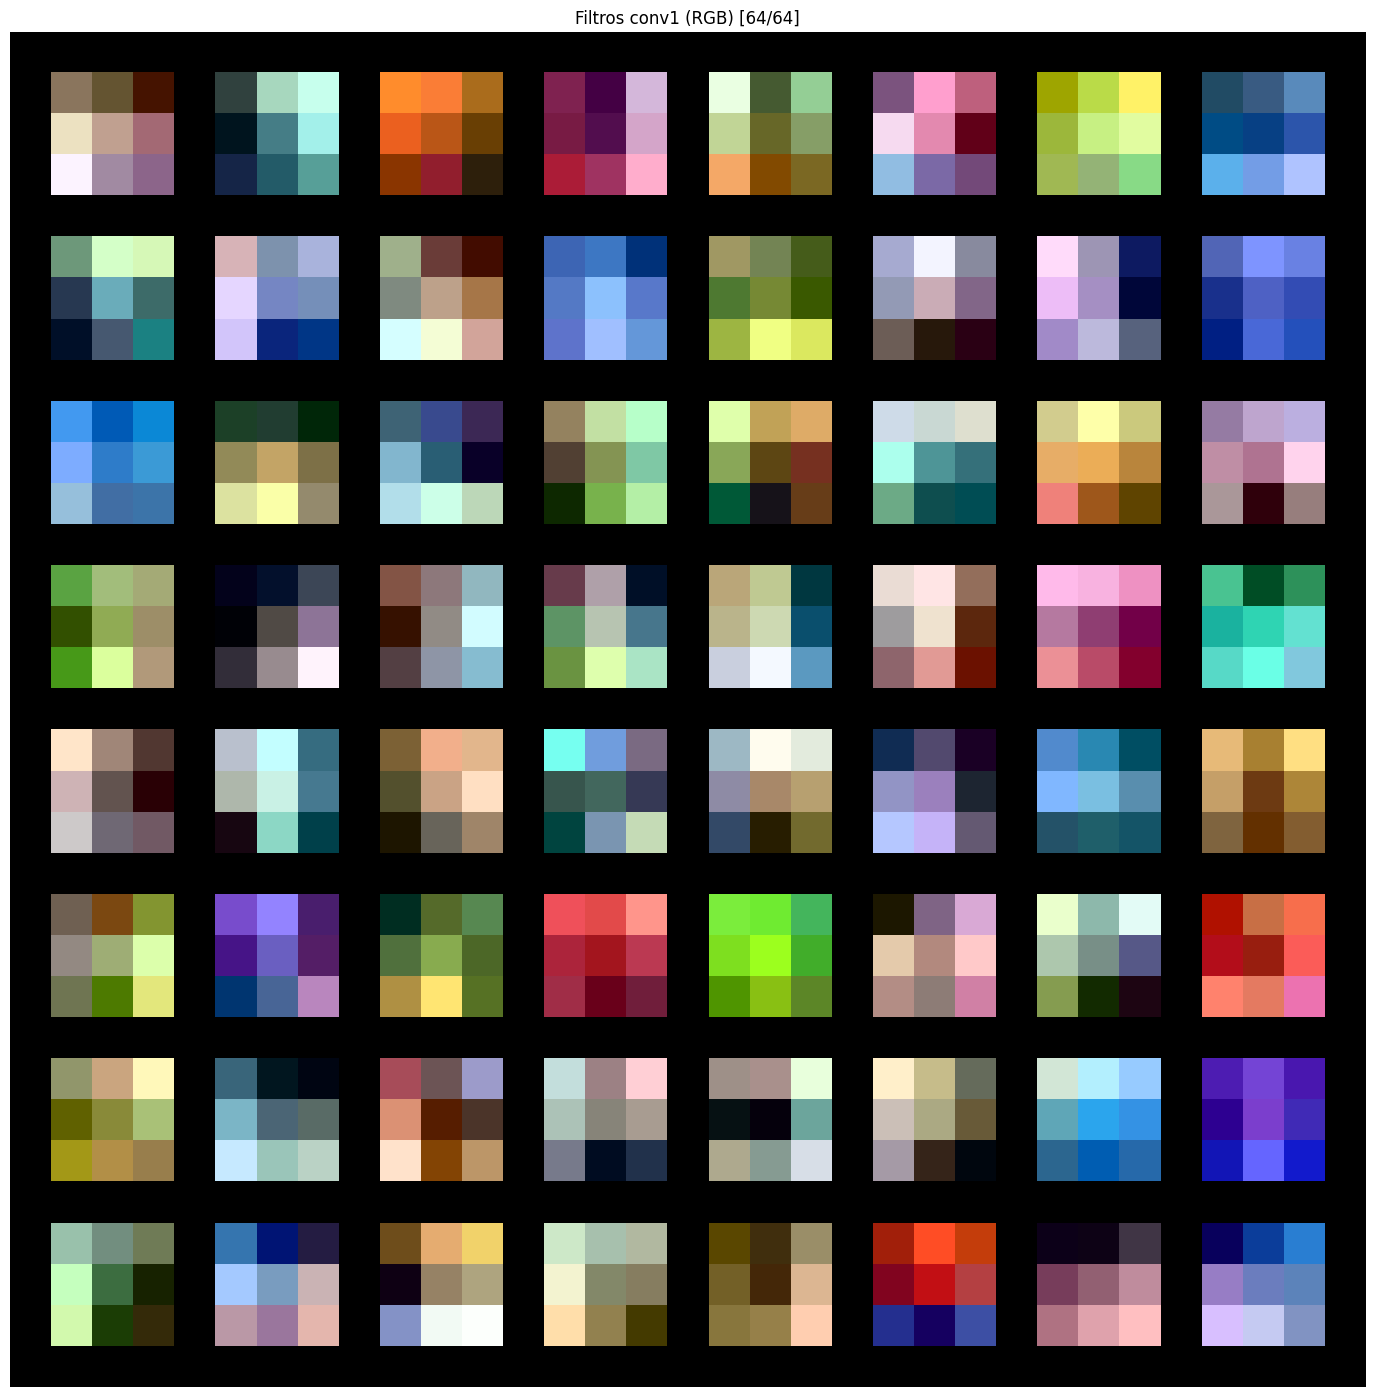

In [26]:
show_first_conv_filters(model, layer_name="conv1", max_filters=64, ncols=8)

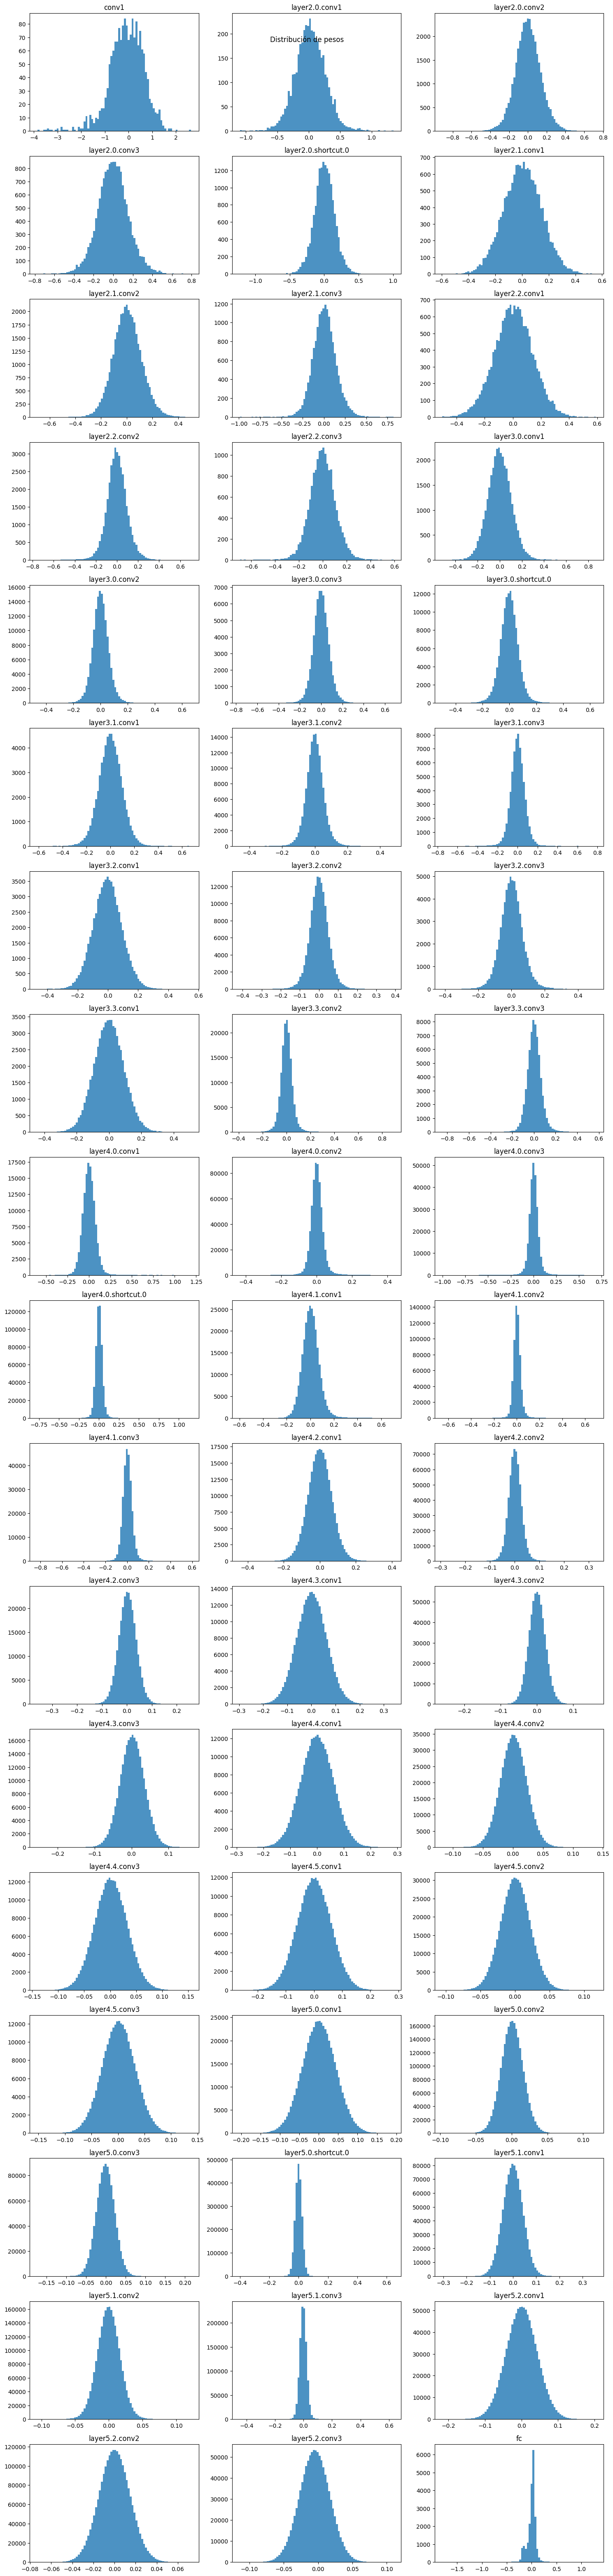

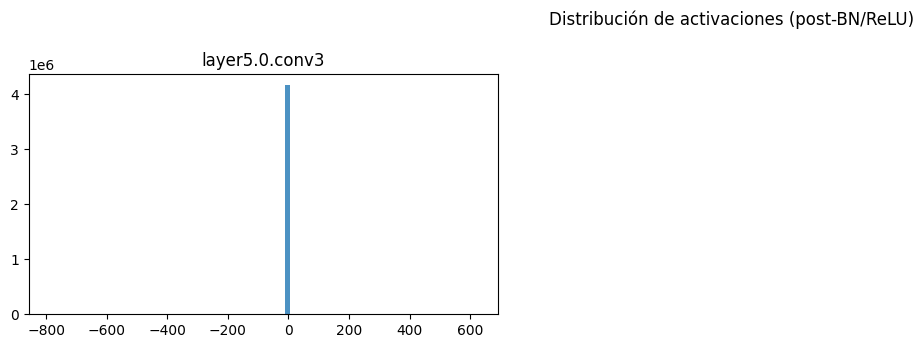

In [35]:
plot_weight_histograms(model)

plot_activation_histograms(model, xb, layer_names=["layer5.0.conv3",])

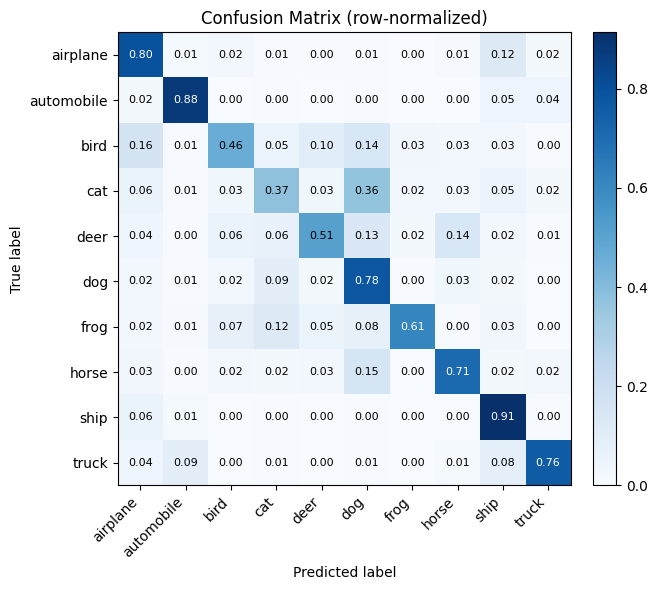

    airplane:  79.9%
  automobile:  87.8%
        bird:  46.1%
         cat:  37.5%
        deer:  51.1%
         dog:  77.6%
        frog:  61.1%
       horse:  70.8%
        ship:  91.4%
       truck:  75.7%


In [29]:

num_classes = 10
cm = compute_confusion_matrix(test_loader, model, device, num_classes)
plot_confusion_matrix(cm, class_names=classes, normalize='true', title="Confusion Matrix (row-normalized)")
accs = per_class_accuracy(cm)
for i, a in enumerate(accs):
    print(f"{classes[i]:>12s}: {a:5.1f}%")

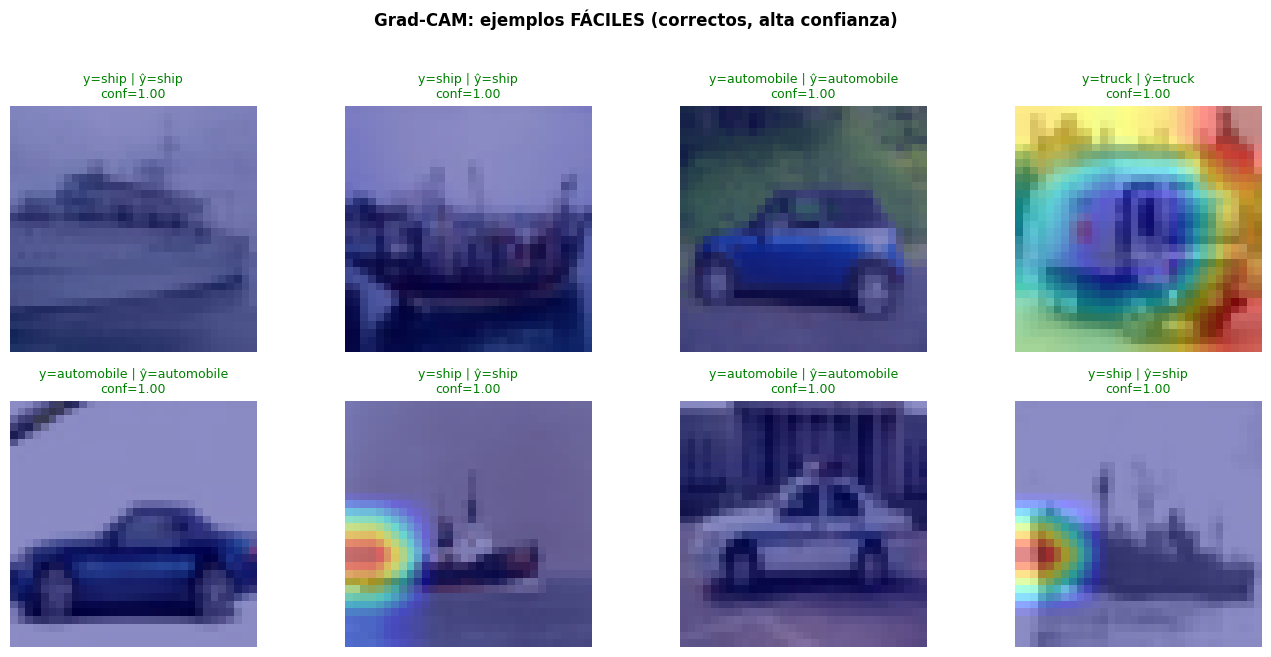

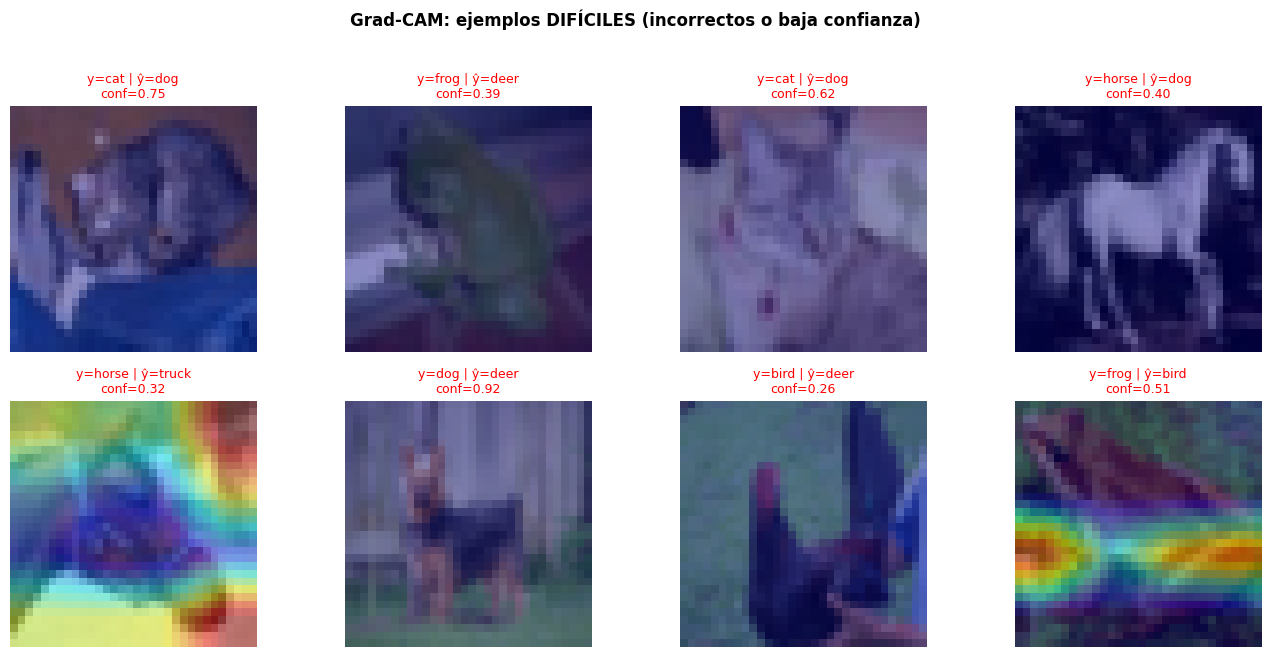

In [33]:

show_gradcam_grid(model, test_loader, device, target_layer="layer5.2.conv3",
                  n_easy=8, n_hard=8, classes=classes)

## Pablo Reyes 
